## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 6-2. Modeling 2 - WS 64 Seed - Logistic Regression

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5-1. Modeling (1) RPI prediction based on stats - XGboost regression
- Step 5-2. Modeling (1) RPI prediction based on stats - Linear regression
- Step 6-1. Modeling (2) WS 64 Seed prediction based on stats - XGboost classification
- Step 6-2. Modeling (2) WS 64 Seed prediction based on stats - Logistic regression

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 500)

In [3]:
y_WSin = pd.read_csv('Data/y_WSin.csv')
y_WSin_2019 = pd.read_csv('Data/y_WSin_2019.csv')

X_famd = pd.read_csv('Data/X_famd.csv')
X_famd_2019 = pd.read_csv('Data/X_famd_2019.csv')
X_College = pd.read_csv('Data/X_College.csv')
X_College_2019 = pd.read_csv('Data/X_College_2019.csv')

X = pd.read_csv('Data/X.csv')
X_2019 = pd.read_csv('Data/X_2019.csv')
X_all = pd.read_csv('Data/Clean_final.csv')

### Add No. WS selected

In [4]:
X_year = pd.DataFrame(X_all[~X_all.RPI_Ranking.isnull()].Year)
print(len(X_year))
print(len(y_WSin_2019)+len(y_WSin))
print(X_year[(X_year.Year < 2013) & (X_year.Year > 2019)])
X_year

2068
2068
Empty DataFrame
Columns: [Year]
Index: []


,Year
0,2019
1,2019
2,2019
3,2019
4,2019
...,...
2063,2013
2064,2013
2065,2013
2066,2013


In [5]:
Y_history_2019 = pd.concat([X_College_2019,y_WSin_2019,X_year[X_year.Year == 2019].reset_index().iloc[:,1]],axis=1,ignore_index=True)
Y_history_2019.columns = ['College','WCWS_in','Year']
print(len(y_WSin_2019))
Y_history_2019

297


,College,WCWS_in,Year
0,Oklahoma,1,2019
1,UCLA,1,2019
2,Washington,1,2019
3,Arizona,1,2019
4,Florida State,1,2019
5,Alabama,1,2019
6,Minnesota,1,2019
7,Texas,1,2019
8,Oklahoma State,1,2019
9,Florida,1,2019


In [6]:
Y_history = pd.concat([X_College,y_WSin,X_year[X_year.Year < 2019].reset_index().iloc[:,1]],axis=1,ignore_index=True)
Y_history.columns = ['College','WCWS_in','Year']
print(len(y_WSin))
Y_history

1771


,College,WCWS_in,Year
0,Florida State,1,2018
1,Oregon,1,2018
2,UCLA,1,2018
3,Oklahoma,1,2018
4,Washington,1,2018
...,...,...,...
1766,Grambling,0,2013
1767,Saint Peter's,0,2013
1768,Morgan State,0,2013
1769,Howard,0,2013


In [7]:
Y_history = pd.concat([X_College,y_WSin,X_year[X_year.Year < 2019].reset_index().iloc[:,1]],axis=1,ignore_index=True)
Y_history.columns = ['College','WCWS_in','Year']
Y_history['WCWS_in_History'] = 0
Y_history_2013 = Y_history[Y_history.Year == 2013][['College','Year','WCWS_in_History']]
print(len(Y_history_2013))

Y_history_2014 = pd.DataFrame(Y_history[Y_history.Year < 2014].groupby(by='College').WCWS_in.sum()).reset_index()
Y_history_2014['Year'] = 2014
Y_history_2014 = Y_history_2014.rename(columns={'WCWS_in':'WCWS_in_History'})
print(len(Y_history_2014))

Y_history_2015 = pd.DataFrame(Y_history[Y_history.Year < 2015].groupby(by='College').WCWS_in.sum()).reset_index()
Y_history_2015['Year'] = 2015
Y_history_2015 = Y_history_2015.rename(columns={'WCWS_in':'WCWS_in_History'})
print(len(Y_history_2015))

Y_history_2016 = pd.DataFrame(Y_history[Y_history.Year < 2016].groupby(by='College').WCWS_in.sum()).reset_index()
Y_history_2016['Year'] = 2016
Y_history_2016 = Y_history_2016.rename(columns={'WCWS_in':'WCWS_in_History'})
print(len(Y_history_2016))

Y_history_2017 = pd.DataFrame(Y_history[Y_history.Year < 2017].groupby(by='College').WCWS_in.sum()).reset_index()
Y_history_2017['Year'] = 2017
Y_history_2017 = Y_history_2017.rename(columns={'WCWS_in':'WCWS_in_History'})
print(len(Y_history_2017))

Y_history_2018 = pd.DataFrame(Y_history[Y_history.Year < 2018].groupby(by='College').WCWS_in.sum()).reset_index()
Y_history_2018['Year'] = 2018
Y_history_2018 = Y_history_2018.rename(columns={'WCWS_in':'WCWS_in_History'})
print(len(Y_history_2018))

Y_history_2019 = pd.DataFrame(Y_history[Y_history.Year < 2019].groupby(by='College').WCWS_in.sum()).reset_index()
Y_history_2019['Year'] = 2019
Y_history_2019 = Y_history_2019.rename(columns={'WCWS_in':'WCWS_in_History'})
print(len(Y_history_2019))

293
291
293
297
299
300
301


In [8]:
Y_history_all = Y_history_2018.append(Y_history_2017).append(Y_history_2016).append(Y_history_2015).append(Y_history_2014).append(Y_history_2013)
print(Y_history_all[(Y_history_all.Year < 2013) & (Y_history_all.Year > 2019)])
Y_history_all

Empty DataFrame
Columns: [College, WCWS_in_History, Year]
Index: []


,College,WCWS_in_History,Year
0,A&M-Corpus Christi,0,2018
1,Abilene Christian,0,2018
2,Akron,0,2018
3,Alabama,5,2018
4,Alabama A&M,0,2018
...,...,...,...
1766,Grambling,0,2013
1767,Saint Peter's,0,2013
1768,Morgan State,0,2013
1769,Howard,0,2013


In [9]:
len(set(X_College.College))

301

In [10]:
X_ext = pd.concat([X_College,X_year[X_year.Year < 2019].reset_index().iloc[:,1],X],axis=1)
X_ext = X_ext.merge(Y_history_all,how='left',on=['College','Year']).drop_duplicates().reset_index().drop(columns='index')
X_ext = X_ext.fillna(0)
X_ext[X_ext.isnull().any(axis=1)]

,College,Year,Fielding_Percentage,Scoring,Hit_Batters,Earned_Run_Average,Triples_per_Game,Home_Runs_per_game,Slugging_Percentage,Double_Plays_per_Game,On_Base_Percentage,Stolen_Bases_per_Game,Strikeout-to-Walk_Ratio,Batting_Average,Doubles_per_Game,Shutouts,Team_Strikeouts_Per_Seven_Innings,Conf__ACC,Conf__ASUN,Conf__America East,Conf__Atlantic 10,Conf__Big 12,Conf__Big East,Conf__Big Sky,Conf__Big South,Conf__Big Ten,Conf__Big West,Conf__C-USA,Conf__CAA,Conf__Horizon,Conf__IVY,Conf__Ivy,Conf__MAAC,Conf__MAC,Conf__MEAC,Conf__MVC,Conf__MWC,Conf__NEC,Conf__OVC,Conf__Pac-12,Conf__Patriot,Conf__SEC,Conf__SWAC,Conf__SoCon,Conf__Southland,Conf__Summit,Conf__Sun Belt,Conf__WAC,Conf__WCC,WCWS_in_History


In [11]:
Y_history_2019

,College,WCWS_in_History,Year
0,A&M-Corpus Christi,0,2019
1,Abilene Christian,0,2019
2,Akron,0,2019
3,Alabama,6,2019
4,Alabama A&M,0,2019
5,Alabama State,1,2019
6,Albany (NY),3,2019
7,Alcorn,0,2019
8,Appalachian State,0,2019
9,Arizona,6,2019


In [12]:
X_ext_2019 = pd.concat([X_College_2019,X_year[X_year.Year == 2019].reset_index().iloc[:,1],X_2019],axis=1)
X_ext_2019 = X_ext_2019.merge(Y_history_2019,how='left',on=['College','Year']).drop_duplicates().reset_index().drop(columns='index')
X_ext_2019 = X_ext_2019.fillna(0)
X_ext_2019[X_ext_2019.isnull().any(axis=1)]

,College,Year,Fielding_Percentage,Scoring,Hit_Batters,Earned_Run_Average,Triples_per_Game,Home_Runs_per_game,Slugging_Percentage,Double_Plays_per_Game,On_Base_Percentage,Stolen_Bases_per_Game,Strikeout-to-Walk_Ratio,Batting_Average,Doubles_per_Game,Shutouts,Team_Strikeouts_Per_Seven_Innings,Conf__ACC,Conf__ASUN,Conf__America East,Conf__Atlantic 10,Conf__Big 12,Conf__Big East,Conf__Big Sky,Conf__Big South,Conf__Big Ten,Conf__Big West,Conf__C-USA,Conf__CAA,Conf__Horizon,Conf__IVY,Conf__Ivy,Conf__MAAC,Conf__MAC,Conf__MEAC,Conf__MVC,Conf__MWC,Conf__NEC,Conf__OVC,Conf__Pac-12,Conf__Patriot,Conf__SEC,Conf__SWAC,Conf__SoCon,Conf__Southland,Conf__Summit,Conf__Sun Belt,Conf__WAC,Conf__WCC,WCWS_in_History


### PCA

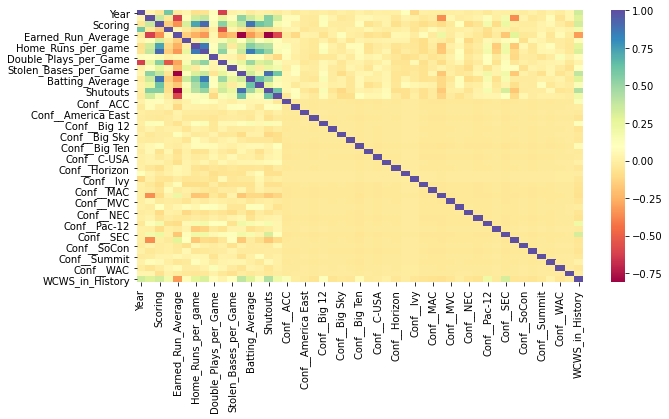

In [13]:
corrMatrix = X_ext.corr()
sn.heatmap(corrMatrix, annot=False, cmap="Spectral")
plt.show()

In [14]:
corrMatrix_abs = pd.DataFrame(corrMatrix.abs().unstack().sort_values(kind="quicksort",ascending=False))
corrMatrix_abs.columns = ['rho']
corrMatrix_abs = corrMatrix_abs[corrMatrix_abs.rho < 1]
print(corrMatrix_abs[corrMatrix_abs.rho >= 0.5].iloc[::2].shape[0])
corrMatrix_abs[corrMatrix_abs.rho >= 0.5].iloc[::2]

25


,,rho
Scoring,Slugging_Percentage,0.914499
Shutouts,Strikeout-to-Walk_Ratio,0.899187
Scoring,Batting_Average,0.883698
Slugging_Percentage,Home_Runs_per_game,0.864282
Batting_Average,Slugging_Percentage,0.857250
Earned_Run_Average,Shutouts,0.809600
Strikeout-to-Walk_Ratio,Earned_Run_Average,0.807919
Home_Runs_per_game,Scoring,0.727264
Slugging_Percentage,Doubles_per_Game,0.664644
Batting_Average,Doubles_per_Game,0.623189


In [15]:
pca = PCA(n_components=15)
scaler = StandardScaler()

In [16]:
X_PCA = pd.DataFrame(scaler.fit_transform(X_ext.iloc[:,2:17]))
X_PCA.columns = X_ext.columns[2:17]
X_PCA

,Fielding_Percentage,Scoring,Hit_Batters,Earned_Run_Average,Triples_per_Game,Home_Runs_per_game,Slugging_Percentage,Double_Plays_per_Game,On_Base_Percentage,Stolen_Bases_per_Game,Strikeout-to-Walk_Ratio,Batting_Average,Doubles_per_Game,Shutouts,Team_Strikeouts_Per_Seven_Innings
0,1.608387,1.389863,0.885290,-1.689324,1.902510,1.456356,1.591525,1.764638,0.104897,2.515816,1.785371,0.509587,1.979028,2.551912,0.714941
1,1.279957,1.624377,1.757663,-1.775785,-0.312502,1.943079,1.934517,0.701093,0.303572,0.661666,3.754985,1.665119,0.882692,2.551912,0.725458
2,0.951528,1.821369,1.757663,-1.451556,0.990447,1.326563,1.869185,-0.096566,0.402909,-0.656841,3.785427,2.120329,0.756192,2.798754,0.725458
3,2.347354,2.140307,1.224546,-1.963118,-0.573091,2.202665,2.065180,-0.539710,1.065155,0.435048,4.397316,1.630103,0.250191,3.539281,0.946315
4,1.772602,1.305439,1.176081,-1.919887,0.469267,1.002081,1.379197,-0.539710,0.071785,0.476251,4.388184,1.279942,1.599527,2.897491,0.725458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,-3.974916,-0.476866,-0.277874,2.374345,1.772216,-1.074606,-0.662422,-1.425997,0.349929,0.023014,-1.377580,-0.610930,-0.171477,-1.348197,-0.836314
1767,-0.690620,-1.414920,-0.423270,2.720190,-0.599150,-0.944813,-0.940083,0.878350,0.349929,-1.274891,-1.383669,-0.786011,0.587525,-1.397565,-0.836314
1768,0.048346,-0.917751,-0.229409,2.763420,0.469267,-1.009710,-1.185077,0.966979,0.349929,-1.192484,-1.420199,-1.451317,-0.424477,-1.348197,-0.836314
1769,-5.452849,-1.658814,-0.617131,3.685672,0.208678,-1.009710,-1.756730,-0.096566,0.396286,-0.924662,-1.761153,-2.081608,-2.701482,-1.446934,-0.836314


In [17]:
X_PCA_2019 = pd.DataFrame(scaler.fit_transform(X_ext_2019.iloc[:,2:17]))
X_PCA_2019.columns = X_ext.columns[2:17]
X_PCA_2019

,Fielding_Percentage,Scoring,Hit_Batters,Earned_Run_Average,Triples_per_Game,Home_Runs_per_game,Slugging_Percentage,Double_Plays_per_Game,On_Base_Percentage,Stolen_Bases_per_Game,Strikeout-to-Walk_Ratio,Batting_Average,Doubles_per_Game,Shutouts,Team_Strikeouts_Per_Seven_Innings
0,2.361318,2.858197,-1.359602,-1.797821,1.736535,3.578128,3.629812,-0.414765,2.731238,0.018451,5.163413,2.674413,1.587733,4.061733,0.777792
1,1.440647,2.599323,1.095227,-1.775709,0.614958,1.862779,2.222858,-0.581954,2.124069,0.037532,4.102135,2.494595,0.986554,2.514406,0.953426
2,1.993050,0.892667,-0.482878,-1.746227,-0.132760,0.448368,0.586509,-0.749144,1.069512,-0.305922,4.394528,0.984121,-0.015411,3.288069,1.429338
3,1.624781,2.071985,-0.658223,-1.643040,-0.631238,3.397565,2.574597,-0.080386,1.548856,-1.393525,2.142020,1.739358,-0.095568,1.547327,1.429338
4,1.348580,2.551383,0.218502,-1.451407,1.487295,2.946157,3.048679,0.588372,2.283850,1.544912,2.174508,2.170922,1.507575,2.901238,1.112064
5,1.256513,1.774759,-0.219860,-1.252403,0.116479,1.892873,1.259400,-0.749144,1.676681,2.041012,0.734202,0.480630,-0.857061,1.547327,0.018599
6,1.624781,1.017311,-0.219860,-1.598817,0.490338,1.682216,1.442916,-1.083523,0.941687,-0.534891,2.488559,0.516593,0.986554,2.514406,3.264999
7,0.427910,0.681732,-0.482878,-1.576705,0.614958,0.027054,0.770025,-0.247575,0.877775,0.018451,2.261143,1.163939,0.946475,2.901238,3.525617
8,1.164446,1.362477,0.656865,-0.802801,-0.755858,2.043342,1.580553,2.594645,1.101469,-0.076953,-0.337905,0.552557,1.387340,0.967079,0.029930
9,2.545452,0.183159,1.182900,-1.451407,0.365719,0.538649,0.158306,-0.247575,0.845819,-0.916506,2.456071,-0.202680,-0.857061,3.481485,3.191346


In [18]:
PCA_X = pd.DataFrame(pca.fit_transform(X_PCA))
PCA_X_2019 = pd.DataFrame(pca.transform(X_PCA_2019))

PC = pd.DataFrame(pca.components_)
PC.index = X_PCA_2019.columns
PC

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Fielding_Percentage,0.254242,0.361232,-0.086171,-0.284595,0.126542,0.289669,0.360066,0.039604,0.250292,0.111145,0.290567,0.338781,0.244911,0.339352,0.189666
Scoring,-0.199974,0.242248,-0.121160,0.389238,0.043459,0.238637,0.275553,0.167098,0.156180,-0.082170,-0.381808,0.237033,0.270599,-0.304854,-0.416157
Hit_Batters,-0.130480,0.105939,0.362691,0.050253,0.590458,-0.231215,-0.015986,0.130220,-0.190452,0.586904,-0.094859,0.163252,-0.039502,-0.014889,0.014431
Earned_Run_Average,0.163704,0.043359,0.682651,-0.005116,-0.228378,0.218669,0.120552,0.192631,-0.491760,-0.257077,0.053461,0.018243,0.194103,0.027192,-0.064406
Triples_per_Game,0.255816,-0.076000,-0.174772,-0.079045,-0.028432,-0.068634,-0.101429,0.914478,0.086258,0.028075,0.008961,-0.092643,-0.141741,-0.007052,-0.053672
Home_Runs_per_game,-0.036717,0.072019,0.119608,0.026999,-0.627493,0.225480,0.033902,-0.037500,0.116218,0.660707,-0.029959,-0.031327,-0.247566,0.021451,-0.132731
Slugging_Percentage,-0.524415,-0.016135,-0.074435,0.083397,-0.297953,-0.198030,-0.044780,0.225872,-0.060463,0.086385,0.036858,0.062123,0.497193,0.037911,0.515987
Double_Plays_per_Game,-0.571358,0.087395,0.041984,0.104485,0.167956,0.401775,0.141492,0.158039,-0.021021,-0.199588,0.187499,-0.108329,-0.526037,0.195397,0.128612
On_Base_Percentage,0.333211,-0.010595,0.115859,0.243537,0.049435,0.222403,0.086333,-0.025934,0.142639,-0.009720,-0.405819,-0.054053,-0.170344,-0.262428,0.685679
Stolen_Bases_per_Game,-0.139349,-0.006210,0.556693,-0.114164,-0.036639,-0.225400,-0.101169,0.040381,0.741143,-0.193519,0.028109,0.037228,-0.009482,-0.043195,-0.052114


In [19]:
PCA_X_var = pd.DataFrame()
PCA_X_var['ExplaineInertia'] = pca.explained_variance_ratio_
PCA_X_var['EigenValues'] = pca.singular_values_
PCA_X_var['CummExplaineInertia'] = PCA_X_var.ExplaineInertia.cumsum()
PCA_X_var

,ExplaineInertia,EigenValues,CummExplaineInertia
0,0.386982,101.391200,0.386982
1,0.157329,64.648661,0.544311
2,0.087032,48.083220,0.631343
3,0.085018,47.523582,0.716360
4,0.064531,41.403546,0.780891
5,0.049836,36.385388,0.830727
6,0.039001,32.187980,0.869728
7,0.038127,31.825372,0.907856
8,0.027367,26.963121,0.935223
9,0.022641,24.524506,0.957863


In [20]:
X_PCA_ext = pd.concat([PCA_X,X_ext[['WCWS_in_History']]],axis=1)
X_PCA_ext.columns = list(PCA_X.columns) + ['WCWS_in_History']
X_PCA_ext = pd.concat([X_PCA_ext,X_ext.iloc[:,17:49]],axis = 1)
X_PCA_ext

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,WCWS_in_History,Conf__ACC,Conf__ASUN,Conf__America East,Conf__Atlantic 10,Conf__Big 12,Conf__Big East,Conf__Big Sky,Conf__Big South,Conf__Big Ten,Conf__Big West,Conf__C-USA,Conf__CAA,Conf__Horizon,Conf__IVY,Conf__Ivy,Conf__MAAC,Conf__MAC,Conf__MEAC,Conf__MVC,Conf__MWC,Conf__NEC,Conf__OVC,Conf__Pac-12,Conf__Patriot,Conf__SEC,Conf__SWAC,Conf__SoCon,Conf__Southland,Conf__Summit,Conf__Sun Belt,Conf__WAC,Conf__WCC
0,5.104587,-0.877303,2.429085,1.166183,1.294468,0.298531,0.157435,-0.203335,-0.556213,-0.540998,1.729316,0.745762,0.261224,-0.362808,0.068479,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.538221,-1.553258,0.163674,2.459181,0.099702,0.953501,-0.005728,0.924458,-1.153614,0.506915,-0.173178,0.786680,-0.731786,0.377024,0.006053,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,5.458948,-1.444795,0.332740,2.100589,-0.796620,-0.778566,-0.397048,1.331276,-1.297038,0.917184,-0.825323,0.950561,-0.511526,0.248725,-0.007244,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,6.697602,-2.450811,-0.832492,1.793622,-0.577652,1.224739,-1.016837,0.908150,-0.970368,0.544174,-0.599030,1.320344,-0.242035,0.337251,0.061565,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5.484350,-2.531001,0.152820,1.776463,-0.760885,-0.162434,-0.162726,-0.053028,-1.755156,0.168298,0.067691,1.389823,-0.600582,0.485985,-0.006808,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,-3.391881,2.183539,1.599025,-2.146360,-2.179426,-0.940044,1.027443,1.527799,-0.493651,0.614697,0.384234,0.466477,0.055846,0.005789,0.022942,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1767,-3.289027,1.976122,-0.908928,-0.293915,0.796562,-0.755620,0.825962,-0.553943,0.414154,0.460623,-0.084009,1.341629,-0.196139,-0.421946,-0.073035,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1768,-3.376815,1.480952,-0.236418,-0.520289,1.197210,-1.091299,-0.391755,-0.196564,0.912461,0.427115,0.003325,1.594872,0.424218,-0.009505,0.012631,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1769,-6.415533,1.840873,0.194588,-2.502688,-0.675801,-0.006248,1.306660,3.797587,-0.177491,0.876943,-0.118286,0.847075,0.235374,-0.350869,-0.032259,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
X_PCA_2019_ext = pd.concat([PCA_X_2019,X_ext_2019[['WCWS_in_History']]],axis=1)
X_PCA_2019_ext.columns = list(PCA_X_2019.columns) + ['WCWS_in_History']
X_PCA_2019_ext = pd.concat([X_PCA_2019_ext,X_ext_2019.iloc[:,17:49]],axis = 1)
X_PCA_2019_ext

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,WCWS_in_History,Conf__ACC,Conf__ASUN,Conf__America East,Conf__Atlantic 10,Conf__Big 12,Conf__Big East,Conf__Big Sky,Conf__Big South,Conf__Big Ten,Conf__Big West,Conf__C-USA,Conf__CAA,Conf__Horizon,Conf__IVY,Conf__Ivy,Conf__MAAC,Conf__MAC,Conf__MEAC,Conf__MVC,Conf__MWC,Conf__NEC,Conf__OVC,Conf__Pac-12,Conf__Patriot,Conf__SEC,Conf__SWAC,Conf__SoCon,Conf__Southland,Conf__Summit,Conf__Sun Belt,Conf__WAC,Conf__WCC
0,9.815137,-0.499360,-1.177277,-0.319417,-0.536671,-0.554309,-1.277737,1.508814,-1.286687,-0.118207,0.152911,1.955745,-0.866408,0.203385,-0.013457,6.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6.959541,-1.038374,-0.210555,0.937133,-1.001858,0.102440,-0.551385,0.880475,-0.872486,1.512246,-0.663716,0.974887,-0.625163,0.840586,-0.121305,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,4.889474,-3.519646,-1.384521,-0.101015,-0.172974,-0.237097,-0.427458,0.449335,-1.224587,0.257137,-0.900348,1.520994,-0.290011,0.263529,-0.108843,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,5.731232,-0.044955,-2.554430,0.771174,-0.168351,0.226721,-0.870070,1.659280,0.853291,-0.022389,-0.466867,-0.370217,-0.453395,0.438944,-0.054142,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,7.496715,0.437840,0.858697,0.208888,-0.023137,0.627915,-0.272151,1.000891,0.126171,0.418404,0.694630,0.695342,-0.116642,-0.413201,0.019751,6.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,3.664158,-0.387174,0.293271,-0.892890,-0.348515,2.195296,-1.636823,0.535541,0.272372,0.072422,0.422841,-0.047925,0.581711,0.022146,0.006957,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,5.068997,-2.529858,-1.202202,0.255746,-1.055630,-0.853054,0.517174,0.665309,1.179344,-0.156963,0.421057,0.664761,0.006069,-0.025037,0.031550,6.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4.356616,-2.819042,-0.136205,-0.570099,-0.412345,-1.041374,1.893971,0.612247,0.444091,0.166644,-0.458098,0.396992,0.105427,-0.539155,0.011422,6.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,3.157979,1.535464,-0.617298,1.775796,2.070233,0.746869,0.277873,0.057172,0.535939,0.584417,0.805160,-0.302892,0.597040,-0.498732,0.038703,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,3.605617,-4.425976,-0.836995,0.915281,0.269066,-0.782559,-0.525392,0.909946,1.352159,0.864698,-0.374521,1.252138,0.634746,-0.769429,-0.041722,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Logistic regression

In [63]:
X_famd_ext = pd.concat([X_famd,X_ext[['WCWS_in_History']]],axis=1)
X_famd_ext.columns = list(X_famd.columns) + ['WCWS_in_History']
X_famd_ext

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,WCWS_in_History
0,2.170850,-0.027647,0.127369,1.219246,0.368641,-0.196787,-0.130418,-0.171609,-0.352457,0.058697,-0.383129,0.073038,1.005647,0.595547,0.468127,-0.074023,-0.904480,0.720769,-0.207444,-0.485857,-0.214408,-0.676500,-0.153969,-0.128498,-0.310688,-0.043215,0.134537,0.032437,-0.287246,0.018377,0.098459,-0.270373,-0.335707,-0.448651,0.572197,0.410523,-0.068122,-0.046195,0.043469,-0.303446,-0.294815,-0.532836,0.235490,-0.178836,-0.052232,-0.010824,0.022264,5.0
1,2.494396,-0.349768,-0.344156,-0.027539,-0.393484,-0.083979,-0.645833,1.197497,-0.807566,0.329022,-0.167865,-0.454194,0.645177,0.477687,-0.396526,0.407270,0.098008,-0.408822,0.217627,0.550522,0.343296,0.310762,-0.242690,0.102283,0.435957,0.295430,-0.019137,-0.204928,0.257748,-0.033217,-0.076521,0.637219,-0.116861,-0.095138,0.027686,0.371716,0.534058,0.189141,-0.112994,-0.270728,-0.008564,-0.010155,0.190365,0.201579,-0.095771,-0.000673,0.000086,5.0
2,2.457301,-0.283095,-0.206933,-0.126478,-0.400174,0.167933,-0.737496,1.330876,-0.816391,0.307917,-0.206095,-0.494546,0.657509,0.443358,-0.414156,0.395289,0.065043,-0.445311,0.208540,0.538905,0.336216,0.306693,-0.206007,0.090296,0.440320,0.308226,-0.028989,-0.224333,0.258356,-0.020713,-0.057799,0.639894,-0.185656,-0.244586,-0.110804,-0.140564,0.020098,0.134771,-0.115916,-0.294089,0.135937,0.302643,0.244900,0.082033,-0.046263,-0.009489,-0.004715,5.0
3,2.908420,-0.812397,-0.120084,-0.298639,0.672517,0.069064,0.087966,0.139732,0.310211,0.063894,0.114614,-0.022350,0.665968,0.105203,-0.150634,-0.645803,0.153987,-0.398356,0.099389,0.377348,0.142229,0.649320,0.818685,0.093924,-0.460005,-1.153012,-0.532278,1.535312,-0.473104,0.152722,-0.480115,0.391411,-0.465212,0.441163,-0.201934,0.192078,0.115855,0.443823,-0.596109,-0.125310,0.085299,0.075666,0.421896,0.160937,0.093301,-0.004882,0.025164,5.0
4,2.452516,-0.725179,-0.179109,-0.183864,-0.318930,0.200328,-0.708240,1.214912,-0.771176,0.350310,-0.168707,-0.451476,0.672903,0.490794,-0.377889,0.386218,0.058440,-0.463347,0.218717,0.552809,0.343879,0.272640,-0.235689,0.091781,0.435474,0.315789,-0.024178,-0.214399,0.252061,-0.025570,-0.038579,0.615931,-0.221270,-0.344349,-0.016926,0.053174,0.357887,-0.270456,-0.212351,-0.516283,-0.072864,-0.125879,0.404643,0.165810,-0.036130,0.006442,-0.008450,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,-1.576332,1.255526,1.910295,-0.489084,0.373753,0.374112,-0.010571,0.200465,-0.262061,0.085850,-0.452627,-1.138265,-0.274432,0.114759,-0.170483,0.045196,0.035416,0.859318,-0.185110,0.271632,0.108343,0.085815,0.268740,-0.175891,-0.006373,0.022172,-0.114014,-0.008376,0.015981,0.208221,-0.145347,0.156257,-0.115912,-0.126489,-0.442039,-0.068734,-0.447081,0.166669,0.268559,-0.250718,0.294789,-0.176367,0.126235,-0.055403,-0.045445,0.007202,-0.003874,0.0
1767,-1.416091,0.653710,-0.658982,-0.416156,-0.399070,0.115220,-0.068207,0.098661,1.324038,0.268193,0.117104,-0.121570,-0.031476,1.534599,-0.368849,0.316625,0.384952,0.348236,0.117169,-0.206845,-0.115074,0.041575,0.038416,-0.131838,0.012904,-0.184765,0.146365,-0.143698,-0.129173,-0.207937,0.012678,-0.385738,0.158836,0.081199,0.257246,-0.010217,-0.262025,-0.104110,0.292371,0.144993,0.306041,0.005120,0.543673,-0.031805,-0.142652,0.006903,-0.034562,0.0
1768,-1.569172,0.684162,0.410329,-0.058872,-0.464075,-0.846523,0.073859,0.909421,0.197365,-0.073163,0.469164,0.724147,0.459668,-0.103283,0.101364,-0.322470,-0.230681,-0.535481,-0.000341,-0.077798,0.064122,-0.108465,0.131745,0.008499,-0.065735,-0.037895,0.014311,-0.100288,-0.059576,0.041316,0.180120,-0.235876,0.080774,0.055555,0.075512,0.038477,-0.635899,-0.357871,-0.402062,0.681530,0.088317,-0.293172,0.647119,-0.059781,0.041509,-0.006168,0.007716,0.0
1769,-2.823702,0.846390,1.15

In [64]:
X_famd_2019_ext = pd.concat([X_famd_2019,X_ext_2019[['WCWS_in_History']]],axis=1)
X_famd_2019_ext.columns = list(X_famd_2019.columns) + ['WCWS_in_History']
X_famd_2019_ext

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,WCWS_in_History
0,4.304510,-0.469646,0.073876,-0.333936,0.684356,0.307128,-0.024726,0.343674,0.257459,0.140620,0.098591,-0.032532,0.689260,0.148147,-0.148511,-0.608126,0.096621,-0.450267,0.103921,0.384900,0.127961,0.633909,0.808730,0.079120,-0.455143,-1.129590,-0.534859,1.539765,-0.454570,0.133556,-0.491779,0.302498,-0.376566,0.142036,-0.334388,-0.054311,-0.680900,0.915994,-0.711925,-0.742301,-0.240791,-0.134325,1.153828,0.359739,-0.148404,0.023228,0.022399,6.0
1,3.090974,-0.511935,-0.325766,0.354510,0.078536,0.230672,-0.673867,1.464526,-0.818818,0.311878,-0.183365,-0.519944,0.719986,0.437371,-0.426270,0.394059,0.117189,-0.457092,0.242477,0.623216,0.406006,0.406897,-0.158445,0.070339,0.523177,0.325317,-0.098454,-0.241232,0.327874,-0.043178,-0.103446,0.981412,0.026690,-0.610346,-0.327341,-0.095271,0.397626,0.350173,-0.351366,-0.318840,0.658715,0.155627,0.638942,0.440914,0.055628,0.020892,-0.028290,6.0
2,2.269181,-1.575275,-0.280450,-0.170882,-0.302147,0.098581,-0.753312,1.435109,-0.803372,0.336878,-0.217848,-0.529771,0.684613,0.497602,-0.398605,0.408295,0.055605,-0.462459,0.205439,0.566255,0.360211,0.297568,-0.211339,0.067917,0.435635,0.326289,-0.054185,-0.207215,0.253763,-0.014686,-0.109549,0.784387,-0.580464,-0.386607,-0.279364,0.130982,0.250765,0.065320,-0.458971,-0.548981,0.089604,0.228931,0.842912,0.122165,0.005903,-0.003457,-0.035912,6.0
3,2.514123,-0.101616,-0.876525,-0.313899,-0.267037,-0.127364,-0.605328,1.318149,-0.873945,0.253402,-0.254326,-0.519354,0.649185,0.398299,-0.474707,0.420063,0.063638,-0.415976,0.196206,0.511011,0.317883,0.364491,-0.192562,0.106928,0.417602,0.305734,-0.018249,-0.236774,0.279178,-0.013719,-0.093243,0.698170,-0.160595,0.102661,-0.560687,-0.007762,0.218820,0.534290,-0.098414,0.383544,-0.185575,-0.034501,-0.092797,0.266678,-0.048436,-0.017759,-0.004015,6.0
4,3.132038,0.232869,-0.074418,1.246265,0.831495,-0.196083,-0.076208,0.089125,-0.378806,0.016739,-0.400303,0.005500,1.073908,0.540765,0.383549,-0.081489,-0.884502,0.721752,-0.194161,-0.440282,-0.184212,-0.555228,-0.064506,-0.152349,-0.269374,-0.047093,0.085891,0.010197,-0.239333,0.015569,0.059281,-0.039572,-0.149458,-0.690091,-0.132170,0.134998,0.051139,0.573466,-0.036414,-0.098535,0.110875,-0.179562,0.475533,-0.142058,-0.206398,-0.013045,0.032161,6.0
5,1.672805,-0.366488,0.441907,0.562528,0.845827,-0.850834,-0.347206,0.355391,1.013223,-0.279213,-0.214994,-0.139782,-0.789470,-0.442891,0.016195,0.448833,-0.276524,0.007331,-0.027250,-0.160188,0.116243,-0.084871,-0.133174,0.091294,0.060410,0.135771,-0.021961,-0.130024,0.091621,0.093495,0.059111,0.394583,-0.023996,0.470487,0.036350,-0.402792,0.707228,0.275448,-0.158481,0.051064,-0.025088,-0.292413,-0.026749,-0.044446,0.119189,-0.009810,-0.004436,6.0
6,2.123699,-1.093847,-0.198892,0.257964,0.002458,0.550728,1.912924,0.567200,-0.145014,-0.220894,-0.349065,-0.082442,-0.229784,0.219848,-0.019343,0.281775,-0.217017,-0.385844,0.040270,0.112957,0.090172,-0.135109,0.132817,-0.213890,0.029257,0.014621,-0.060891,-0.141865,0.019818,0.033498,-0.054584,0.383641,-0.297192,-0.528413,-0.709824,-0.085535,-0.260939,0.223760,-0.064474,0.060613,-0.033421,-0.219825,0.432985,-0.071522,-0.088718,-0.021777,0.029981,6.0
7,1.936783,-1.257695,0.274723,0.097142,0.476595,0.468609,0.205733,0.310264,0.393851,0.086433,0.154664,-0.008882,0.699741,0.058048,-0.155653,-0.678427,0.147907,-0.337740,0.088508,0.391951,0.112223,0.699050,0.818470,0.107064,-0.399406,-1.098127,-0.546863,1.560907,-0.430453,0.152113,-0.525097,0.571293,-0.593707,0.063354,-0.031298,0.333335,-0.589395,0.039350,0.545872,-0.301051,0.232367,0.150305,0.295080,-0.159481,-0.047449,-0.021806,0.018618,6.0
8,1.356034,0.515116,-0.800003,0.829663,0.531999,0.039189,0.211620,0.025746,0.381378,0.046561,0.161065,0.051019,0.592714,0.036407,-0.153395,-0.634759,0.216109,-0.333053,0.097173,0.419174,0.152462,0.750360,0.793581,0.144467,-0.345203,-1.1130

In [65]:
X_famd_ext.to_csv('Data/X_famd_ext.csv',index=False)
X_famd_2019_ext.to_csv('Data/X_famd_2019_ext.csv',index=False)

WCWS_in
0          1387
1           384
dtype: int64
Proportion 0:  0.7831733483907397


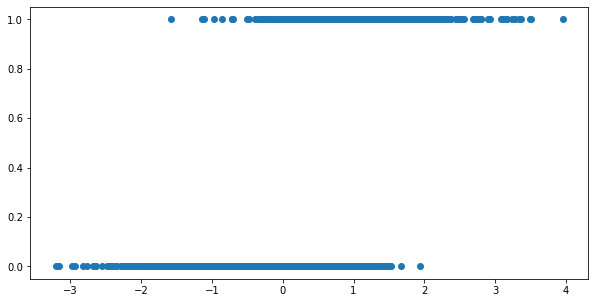

In [23]:
plt.scatter(X_famd_ext['0'],y_WSin)
plt.show

print(y_WSin.value_counts())
print('Proportion 0: ', y_WSin.value_counts()[0]/len(y_WSin))

In [ ]:
w = y_WSin*(1387/384 - 1) + 1

In [26]:
logistic = LogisticRegression(C=1e4, solver='lbfgs', multi_class='auto',class_weight = None)
logistic.fit(X_famd_ext, y_WSin)
print('Train set score:', logistic.score(X_famd_ext, y_WSin))
print(confusion_matrix(y_WSin,logistic.predict(X_famd_ext)))

print('\n\nTest set score:', logistic.score(X_famd_2019_ext, y_WSin_2019))
print(confusion_matrix(y_WSin_2019,logistic.predict(X_famd_2019_ext)))

Train set score: 0.9045736871823828
[[1339   48]
 [ 121  263]]


Test set score: 0.8888888888888888
[[220  13]
 [ 20  44]]


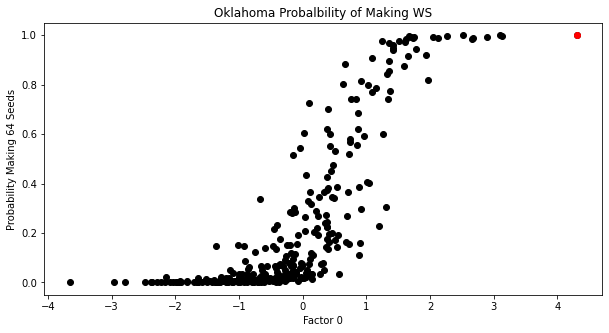

In [142]:
prob_in = logistic.predict_proba(X_famd_2019)[:,1]

idx_ex = 0
college = X_College_2019.College.loc[idx_ex]
prob_college = prob_in[idx_ex]

plt.scatter(X_famd_2019['0'],prob_in,color='k')
plt.scatter(X_famd_2019['0'][idx_ex],prob_in[idx_ex],color='r')
plt.title(college + ' Probalbility of Making WS')
plt.ylabel('Probability Making 64 Seeds')
plt.xlabel('Factor 0')
plt.show()

In [27]:
# boostrap resampling to generate prediction probability
n_bootstrap = 1000

y_ex = y_WSin_2019
X_ex = pd.DataFrame(X_famd_2019_ext)
scores = []
df_prob_in = pd.DataFrame()
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_WSin)), replace=True, n_samples=len(y_WSin))
    X_i = X_famd_ext.iloc[idx_resample]
    y_i = y_WSin.iloc[idx_resample]
    logistic.fit(X_i,y_i)
    idx_test = y_WSin.index[~y_WSin.index.isin(y_i.index)]
    scores.append(logistic.score(X_famd_ext.loc[idx_test],y_WSin.loc[idx_test]))
    prob_in_i = pd.DataFrame(logistic.predict_proba(X_famd_2019_ext)[:,1].reshape([1,-1])).round(decimals=2)
    df_prob_in = df_prob_in.append(prob_in_i,ignore_index = True)

df_prob_in.columns = X_College_2019.College

In [28]:
print(np.round(scores,decimals=3))
print(np.mean(scores))

[0.893 0.9   0.871 0.875 0.883 0.887 0.856 0.854 0.886 0.885 0.882 0.875
 0.858 0.883 0.894 0.893 0.892 0.894 0.868 0.87  0.881 0.891 0.879 0.906
 0.886 0.878 0.878 0.863 0.882 0.889 0.876 0.88  0.896 0.887 0.887 0.898
 0.9   0.873 0.886 0.873 0.885 0.897 0.896 0.892 0.888 0.872 0.878 0.892
 0.909 0.895 0.873 0.883 0.881 0.882 0.894 0.89  0.912 0.873 0.888 0.873
 0.901 0.879 0.894 0.877 0.884 0.88  0.849 0.889 0.864 0.892 0.883 0.867
 0.868 0.892 0.883 0.889 0.891 0.892 0.868 0.883 0.866 0.868 0.886 0.867
 0.866 0.879 0.887 0.87  0.888 0.896 0.899 0.9   0.888 0.887 0.877 0.896
 0.879 0.87  0.891 0.884 0.877 0.886 0.867 0.878 0.882 0.868 0.876 0.879
 0.884 0.887 0.882 0.879 0.87  0.896 0.893 0.867 0.898 0.869 0.881 0.903
 0.879 0.895 0.884 0.882 0.884 0.873 0.893 0.88  0.879 0.894 0.885 0.895
 0.893 0.886 0.881 0.881 0.882 0.872 0.905 0.894 0.888 0.892 0.88  0.884
 0.883 0.881 0.898 0.864 0.883 0.902 0.899 0.865 0.903 0.882 0.882 0.885
 0.878 0.885 0.871 0.87  0.888 0.884 0.883 0.918 0.

In [29]:
df_prob_in.to_csv('WS64Seeds/WS64_prediction_logistic_famd_ext.csv',index = False)
df_prob_in

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.79,1.00,1.00,0.99,1.00,1.00,0.96,1.00,1.0,1.0,0.30,1.00,0.47,0.60,1.00,1.00,1.00,1.00,0.99,0.96,0.98,0.73,0.34,0.57,0.95,0.15,0.34,0.68,0.97,0.79,0.87,0.09,0.16,0.58,0.36,0.26,0.41,0.81,0.89,0.01,0.19,0.89,0.54,0.79,0.00,0.16,0.04,0.13,0.93,0.13,0.09,0.90,0.65,0.18,0.66,0.11,0.04,0.97,0.07,0.26,0.56,0.08,0.01,0.56,0.17,0.04,0.01,0.08,0.44,0.18,0.15,0.22,0.97,0.23,0.01,0.04,0.15,0.10,0.01,0.01,0.06,0.07,0.03,0.05,0.35,0.15,0.11,0.36,0.66,0.27,0.03,0.07,0.19,0.08,0.14,0.00,0.90,0.28,0.04,0.04,0.00,0.02,0.00,0.43,0.03,0.05,0.11,0.0,0.00,0.02,0.01,0.04,0.00,0.03,0.0,0.03,0.39,...,0.00,0.0,0.01,0.00,0.00,0.01,0.0,0.00,0.01,0.00,0.53,0.03,0.00,0.01,0.0,0.39,0.00,0.0,0.05,0.0,0.03,0.0,0.0,0.04,0.01,0.00,0.0,0.04,0.00,0.04,0.00,0.0,0.00,0.03,0.0,0.04,0.0,0.03,0.02,0.00,0.45,0.0,0.00,0.00,0.79,0.32,0.02,0.0,0.08,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.00,0.01,0.0,0.0,0.0,0.11,0.02,0.00,0.0,0.01,0.02,0.04,0.02,0.27,0.00,0.00,0.0,0.00,0.0,0.00,0.02,0.02,0.0,0.0,0.0,0.01,0.0,0.0,0.19,0.0,0.0,0.03,0.0,0.04,0.0,0.02,0.00,0.01,0.0,0.02,0.01,0.00,0.00,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.06,0.0,0.0,0.01,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.93,1.00,1.

In [30]:
df_prob_in_5 = (df_prob_in*100/5).round(0)*5

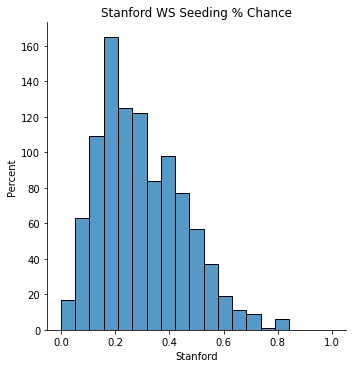

Actual result:  1
Predicted result (% peak chance making into WS):  15.0


In [31]:
idx_ex = 30
college = df_prob_in.columns[idx_ex]
bins = np.linspace(0,1,20)
sn.displot(data=df_prob_in,x=college,kde=False,bins=bins) 
plt.title(college + ' WS Seeding % Chance')
plt.ylabel('Percent')
plt.show()
print('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])
print('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())

### SGD Classifier

In [32]:
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='log', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-6,
              validation_fraction=0.1, verbose=0, warm_start=False)
sgd

SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0, tol=1e-06)

0.8965974025974026


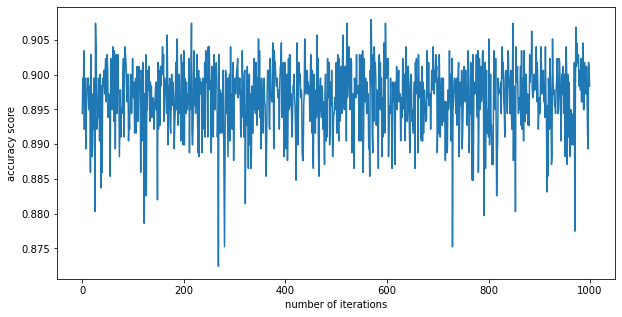

In [67]:
n_bootstrap = 1000

scores_binary = []
df_prob_in = pd.DataFrame()
df_y_predict = pd.DataFrame()
for i in range(n_bootstrap):
    sgd.fit(X_famd_ext, y_WSin)
    scores_binary.append(sgd.score(X_famd_ext, y_WSin))
    prob_in_i = pd.DataFrame(sgd.predict_proba(X_famd_2019_ext)[:,1].reshape([1,-1])).round(decimals=2)
    df_prob_in = df_prob_in.append(prob_in_i,ignore_index = True)
    y_predict_i = pd.DataFrame(sgd.predict(X_famd_2019_ext).reshape([1,-1])).round(decimals=2)
    df_y_predict = df_y_predict.append(y_predict_i,ignore_index = True)
    
    
df_prob_in.columns = X_College_2019.College
df_y_predict.columns = X_College_2019.College

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))

In [68]:
df_SGD = pd.DataFrame(list(X_famd_ext.columns))
df_SGD['Coef'] = pd.DataFrame(sgd.coef_).T
print(len(df_SGD))
print(len(pd.DataFrame(sgd.coef_).T))
df_SGD

48
48


,0,Coef
0,0,3.108846
1,1,-0.651814
2,2,0.115795
3,3,-0.412520
4,4,-0.382276
5,5,-0.398699
6,6,-0.310738
7,7,0.930696
8,8,0.226913
9,9,-0.493280


SGD with logistic regression performs the best.

In [69]:
df_prob_in.to_csv('WS64Seeds/WS64_prediction_SGDlogistic_1000_famd_ext2.csv',index = False)
df_prob_in_5 = (df_prob_in*100/5).round(0)*5
df_prob_in

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.95,1.0,1.0,1.00,1.0,1.0,0.97,1.00,1.0,1.0,0.55,1.00,0.90,0.86,1.00,1.00,1.0,1.00,1.00,0.98,0.99,0.85,0.34,0.86,0.98,0.60,0.45,0.84,1.00,0.71,0.96,0.15,0.34,0.75,0.55,0.64,0.55,0.82,0.98,0.06,0.28,0.97,0.60,0.52,0.02,0.25,0.21,0.49,0.93,0.44,0.34,0.94,0.63,0.14,0.80,0.19,0.07,0.98,0.17,0.44,0.81,0.30,0.01,0.90,0.15,0.31,0.03,0.09,0.71,0.74,0.29,0.57,1.00,0.19,0.03,0.23,0.27,0.14,0.02,0.02,0.07,0.09,0.09,0.06,0.42,0.28,0.07,0.39,0.91,0.37,0.06,0.10,0.29,0.17,0.35,0.0,0.97,0.19,0.05,0.12,0.0,0.03,0.00,0.73,0.08,0.11,0.16,0.0,0.01,0.03,0.03,0.15,0.01,0.09,0.0,0.08,0.47,...,0.01,0.0,0.01,0.02,0.01,0.04,0.0,0.0,0.01,0.01,0.63,0.02,0.01,0.06,0.01,0.43,0.01,0.0,0.02,0.0,0.03,0.0,0.0,0.04,0.01,0.00,0.0,0.06,0.01,0.16,0.0,0.0,0.00,0.07,0.0,0.08,0.0,0.06,0.09,0.01,0.29,0.0,0.0,0.0,0.65,0.33,0.04,0.0,0.21,0.01,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.11,0.06,0.00,0.0,0.01,0.03,0.02,0.04,0.20,0.00,0.0,0.0,0.00,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.12,0.0,0.0,0.03,0.00,0.06,0.0,0.01,0.00,0.00,0.0,0.01,0.00,0.00,0.01,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.00,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.97,1.0,1.0,1.00,1.0,1.

In [70]:
df_prob_in_rank = df_prob_in.rank(axis=1, ascending=False)
df_prob_in_rank = df_prob_in_rank <= 64
df_prob_in_rank = df_prob_in_rank.astype(int)
mean_prob = df_prob_in_rank.mean()
df_WSin_odds = pd.DataFrame(mean_prob/(1-mean_prob)).T
df_WSin_odds[df_WSin_odds > 100] = 100
df_WSin_meanProb = pd.DataFrame(df_prob_in_rank.mean()).T
df_WSin_meanProb

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.856,1.0,0.988,0.998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.959,0.039,0.989,1.0,0.451,0.343,0.999,1.0,0.921,1.0,0.002,0.049,0.786,0.527,0.814,0.687,0.998,1.0,0.0,0.003,0.995,0.699,0.874,0.0,0.007,0.014,0.655,1.0,0.233,0.016,0.971,0.961,0.0,0.971,0.006,0.001,0.999,0.004,0.625,0.999,0.059,0.0,0.999,0.011,0.224,0.0,0.001,0.947,0.388,0.056,0.558,1.0,0.013,0.0,0.004,0.008,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.278,0.006,0.0,0.46,0.998,0.17,0.0,0.0,0.031,0.004,0.012,0.0,0.99,0.013,0.0,0.0,0.0,0.0,0.0,0.827,0.0,0.003,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.409,0.0,0.0,0.0,0.0,0.255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024,0.0,0.0,0.0,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.286,0.0,0.0,0.0,0.965,0.068,0.0,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


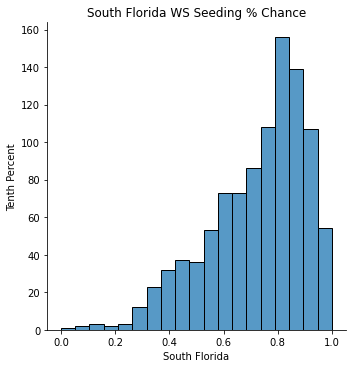

Actual result:  1
Average percent chance making into WS (%): 99.0
Odds making into WS (100 max, >1 indicates greater odds making):  89.91
Predicted result (% peak chance making into WS):  80.0


In [74]:
idx_ex = 31
college = df_prob_in.columns[idx_ex]
bins = np.linspace(0,1,20)
sn.displot(data=df_prob_in,x=college,kde=False,bins=bins) 
plt.title(college + ' WS Seeding % Chance')
plt.ylabel('Tenth Percent')
plt.show()
print('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])
print('Average percent chance making into WS (%):', np.round(df_WSin_meanProb[college][0]*100))
print('Odds making into WS (100 max, >1 indicates greater odds making): ', np.round(df_WSin_odds[college][0],decimals=2))
print('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())

In [72]:
df_WSin_binary = pd.DataFrame(df_WSin_meanProb.rank(axis=1,ascending=False)).T
df_WSin_binary[df_WSin_binary <= 64] = 1
df_WSin_binary[df_WSin_binary > 64] = 0
df_WSin_binary.sum(axis=0)

0    64.0
dtype: float64

In [73]:
print(confusion_matrix(y_WSin_2019,df_WSin_binary))
print('Accuracy(%): ', (215+46)/(214+46+36)*100)
print('Sensitivity:', 46/64)
print('Specificity:', 215/233)

[[215  18]
 [ 18  46]]
Accuracy(%):  88.17567567567568
Sensitivity: 0.71875
Specificity: 0.9227467811158798


### Support Vector Machine Classifier with SGD

0.886465273856578


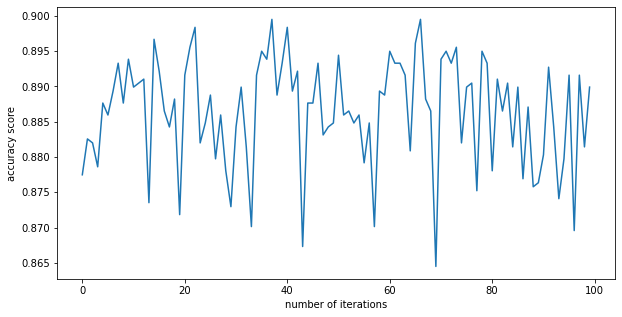

In [127]:
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='hinge', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-6,
              validation_fraction=0.1, verbose=0, warm_start=False)

scores_binary = []
n_bootstrap = 100
for i in range(n_bootstrap):
    sgd.fit(X_famd, y_WSin)
    scores_binary.append(sgd.score(X_famd, y_WSin))

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))

0.8598870694522865


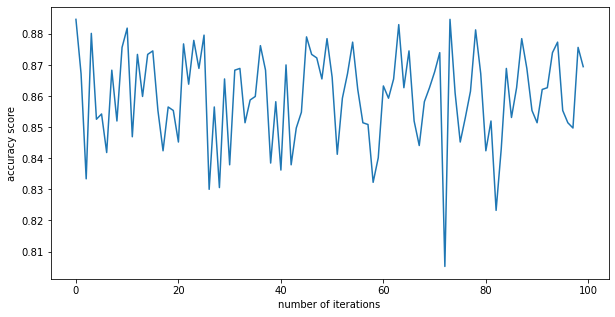

In [128]:
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='modified_huber', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-6,
              validation_fraction=0.1, verbose=0, warm_start=False)

scores_binary = []
n_bootstrap = 100
for i in range(n_bootstrap):
    sgd.fit(X_famd, y_WSin)
    scores_binary.append(sgd.score(X_famd, y_WSin))

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))

0.880408792741133


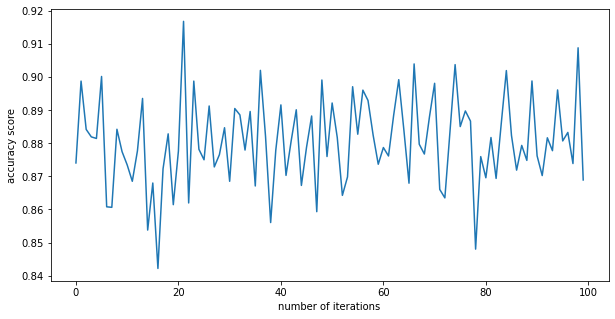

In [239]:
lin_clf = svm.LinearSVC(class_weight=None)
lin_clf.fit(X_famd, y_WSin)

scores_binary = []
n_bootstrap = 100
for i in range(n_bootstrap):
    idx_resample =  resample(range(len(y_WSin)), replace=True, n_samples=len(y_WSin))
    X_i = X_famd.iloc[idx_resample]
    y_i = y_WSin.iloc[idx_resample]
    lin_clf.fit(X_i,y_i)
    idx_test = y_WSin.index[~y_WSin.index.isin(y_i.index)]
    scores_binary.append(lin_clf.score(X_famd.loc[idx_test],y_WSin.loc[idx_test]))

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))

In [249]:
sgd.predict(X_famd_2019)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])